In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the data into DataFrames
train_users = pd.read_csv('./data/train_users_2.csv')
test_users = pd.read_csv('./data/test_users.csv')

In [3]:
# Inspect data 
len(train_users.id.unique()), len(test_users.id.unique()), train_users.shape, test_users.shape

(213451, 62096, (213451, 16), (62096, 15))

In [4]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0)
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


In [5]:
# Change Dates columns to Python Date format
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
#users['date_account_created'].fillna(df_all.timestamp_first_active, inplace=True)

In [6]:
# Extract Date Features
import datetime as dt
users['day_account_created'] = users['date_account_created'].dt.weekday
users['month_account_created'] = users['date_account_created'].dt.month
users['quarter_account_created'] = users['date_account_created'].dt.quarter
users['year_account_created'] = users['date_account_created'].dt.year
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['day_first_active'] = users['timestamp_first_active'].dt.weekday
users['month_first_active'] = users['timestamp_first_active'].dt.month
users['quarter_first_active'] = users['timestamp_first_active'].dt.quarter
users['year_first_active'] = users['timestamp_first_active'].dt.year
users['created_less_active'] = (users['date_account_created'] - users['timestamp_first_active']).dt.days

In [7]:
# Replace null in Gender field
users.gender.replace('-unknown-', np.nan, inplace=True)

In [8]:
# Nullify outliers
users.loc[users['age'] > 90,'age'] = np.NaN
users.loc[users['age'] < 15,'age'] = np.NaN

print len(users[users['age'] > 90])
print len(users[users['age'] < 15])
print len(users[users['age'].isnull()])

0
0
119853


In [9]:
#Plot age distribution again after handling outliers
users = users.fillna({'age':-1})

In [10]:
t_users = users.copy()
t_users = t_users.set_index('id')

cat_features = ['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'gender',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method']
num_features = ['day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'age']
target = ['country_destination']

In [11]:
nogender_cat_features = ['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method']

other_features = ['day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'age',
 'gender']

In [12]:
encode_users = pd.get_dummies(t_users[nogender_cat_features])

In [13]:
encode_users.shape, t_users[num_features].shape

((275547, 132), (275547, 11))

In [14]:
df_users = pd.merge(encode_users, t_users[other_features], how='inner', left_index=True, right_index=True)

In [15]:
df_users.shape

(275547, 144)

In [16]:
# Join/Merge with session data
user_devices = pd.read_csv('./data/user_devices.csv')
user_session = pd.read_csv('./data/user_session_detail.csv')

In [17]:
df_users = df_users.reset_index()

In [18]:
all_users = pd.merge(df_users, user_devices, how='left', left_on='id', right_on='user_id')
all_users = pd.merge(all_users, user_session, how='left', left_on='id', right_on='user_id')

In [19]:
all_users.shape

(275547, 316)

In [20]:
# Split notnull vs null gender
X_gender_users = all_users[all_users['gender'].isnull()==False]
X_pred_gender_users = all_users[all_users['gender'].isnull()]

In [21]:
y_gender_users = X_gender_users['gender']

In [22]:
id_X = X_gender_users.id
id_X_pred = X_pred_gender_users.id

In [23]:
X_gender_users = X_gender_users.drop(['gender','user_id_x','user_id_y','id'], axis=1)
X_pred_gender_users = X_pred_gender_users.drop(['gender','user_id_x','user_id_y','id'], axis=1)

In [24]:
X_gender_users = X_gender_users.fillna(0)
X_pred_gender_users = X_pred_gender_users.fillna(0)

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_y_gender_users = le.fit_transform(y_gender_users)

In [26]:
X_gender_users.shape, X_pred_gender_users.shape

((146067, 312), (129480, 312))

In [27]:
np.bincount(le_y_gender_users)

array([77524, 68209,   334])

In [28]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_gender_users, le_y_gender_users)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [29]:
pred_gender = neigh.predict(X_pred_gender_users)

In [30]:
np.bincount(pred_gender)

array([78235, 51245])

In [31]:
X_pred_gender_users['predicted_gender'] = le.inverse_transform(pred_gender)

In [32]:
impute_gender = pd.DataFrame(X_pred_gender_users['predicted_gender'])

In [33]:
impute_gender.head()

,predicted_gender
0,FEMALE
4,MALE
5,FEMALE
9,FEMALE
12,FEMALE


In [34]:
all_users.shape

(275547, 316)

In [35]:
new_all_users = pd.merge(all_users, impute_gender, how='left', left_index=True, right_index=True)

In [36]:
new_all_users.shape, all_users.shape

((275547, 317), (275547, 316))

In [37]:
new_all_users.head()

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,predicted_gender
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MALE


In [38]:
new_all_users.loc[new_all_users.gender.isnull(),'gender'] = new_all_users['predicted_gender']

In [41]:
new_all_users.head()

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,predicted_gender
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MALE


In [63]:
t_users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,day_account_created,month_account_created,quarter_account_created,year_account_created,hour_first_active,day_first_active,month_first_active,quarter_first_active,year_first_active,created_less_active
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,direct,direct,-1.0,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,NaN,...,0,6,2,2010,4,3,3,1,2009,465
820tgsjxq7,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2,5,2,2011,17,5,5,2,2009,731
4ft3gnwmtx,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,1,9,3,2010,23,1,6,2,2009,475
bjjt8pjhuk,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,0,12,4,2011,6,5,10,4,2009,764
87mebub9p4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,NaN,...,1,9,3,2010,6,1,12,4,2009,279


In [67]:
training_features = cat_features + num_features

In [68]:
training_features

['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'gender',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method',
 'day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'age']

In [69]:
t2_users = t_users[training_features].drop('gender',axis=1).reset_index()

In [71]:
# Prepare features for training
all_users = pd.merge(t2_users, user_devices, how='left', left_on='id', right_on='user_id')
all_users = pd.merge(all_users, user_session, how='left', left_on='id', right_on='user_id')

In [72]:
all_users.head()

,id,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_browser,first_device_type,language,signup_app,signup_flow,signup_method,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,gxn3p5htnn,direct,direct,untracked,Chrome,Mac Desktop,en,Web,0,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,seo,google,untracked,Chrome,Mac Desktop,en,Web,0,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,direct,direct,untracked,IE,Windows Desktop,en,Web,3,basic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,direct,direct,untracked,Firefox,Mac Desktop,en,Web,0,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,direct,direct,untracked,Chrome,Mac Desktop,en,Web,0,basic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
all_users.shape, user_devices.shape, user_session.shape, t2_users.shape

((275547, 192), (135483, 15), (135478, 156), (275547, 21))

In [75]:
all_users = all_users.drop(['user_id_x','user_id_y'],axis=1)

In [79]:
new_all_users[['id','gender']].head()

,id,gender
0,gxn3p5htnn,FEMALE
1,820tgsjxq7,MALE
2,4ft3gnwmtx,FEMALE
3,bjjt8pjhuk,FEMALE
4,87mebub9p4,MALE


In [81]:
all_users = pd.merge(all_users, new_all_users[['id','gender']], how='inner', left_on='id', right_on='id')

In [82]:
any(all_users.gender.isnull())

False

In [83]:
cat_features

['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'gender',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method']

In [84]:
#Label Encoder Category feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in cat_features:
    all_users[col] = le.fit_transform(all_users[col])

In [85]:
all_users.head()

,id,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_browser,first_device_type,language,signup_app,signup_flow,signup_method,...,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender
0,gxn3p5htnn,2,4,7,8,3,6,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,820tgsjxq7,7,8,7,8,3,6,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,4ft3gnwmtx,2,4,7,22,6,6,2,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,bjjt8pjhuk,2,4,7,17,3,6,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,87mebub9p4,2,4,7,8,3,6,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [87]:
all_users.isnull().sum()

id                                       0
affiliate_channel                        0
affiliate_provider                       0
first_affiliate_tracked                  0
first_browser                            0
first_device_type                        0
language                                 0
signup_app                               0
signup_flow                              0
signup_method                            0
day_account_created                      0
month_account_created                    0
quarter_account_created                  0
year_account_created                     0
hour_first_active                        0
day_first_active                         0
month_first_active                       0
quarter_first_active                     0
year_first_active                        0
created_less_active                      0
age                                      0
-unknown-_x                         140064
Android App Unknown Phone/Tablet    140064
Android Pho

In [88]:
all_users = all_users.fillna(0.)

In [89]:
destination = t_users['country_destination'].reset_index()

In [90]:
destination.head()

,id,country_destination
0,gxn3p5htnn,NDF
1,820tgsjxq7,NDF
2,4ft3gnwmtx,US
3,bjjt8pjhuk,other
4,87mebub9p4,US


In [92]:
df_all_users = pd.merge(all_users, destination, how='inner', on='id')

In [93]:
df_all_users.shape

(275547, 192)

In [94]:
# Split train and test data
df_test = df_all_users[df_all_users['country_destination'].isnull()]
df_train = df_all_users[df_all_users['country_destination'].isnull()==False]

In [95]:
df_test.shape, df_train.shape

((62096, 192), (213451, 192))

In [96]:
from sklearn.preprocessing import LabelEncoder
labels = df_train['country_destination']
le = LabelEncoder()
y = le.fit_transform(labels)
X = df_train.drop('country_destination', axis=1, inplace=False)

In [97]:
idtrain = df_train['id']
X = X.drop('id', axis=1, inplace=False)

In [98]:
X.shape, y.shape

((213451, 190), (213451,))

In [99]:
# Model 2
# Grid Search - Used to find best combination of parameters
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

# Skip Grid search for time saving
final_model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=25,
        max_depth=3,
        objective='multi:softprob', 
        subsample=0.5, 
        colsample_bytree=0.5, 
        seed=0)
final_model.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=25, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

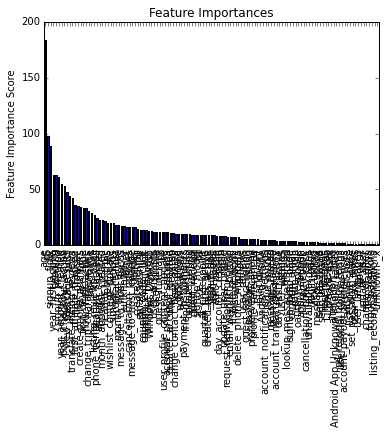

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
feat_imp = pd.Series(final_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [101]:
feat_imp[:30]

age                            184
p5                              98
signup_flow                     89
year_first_active               63
pending                         63
signup_method                   61
year_account_created            55
post_checkout_action            53
view_search_results             48
message_post                    44
translate_listing_reviews       42
first_affiliate_tracked         36
first_browser                   35
create_phone_numbers            34
first_device_type               33
hour_first_active               33
change_trip_characteristics     31
language                        29
listing_reviews_page            27
phone_verification_success      24
affiliate_channel               23
month_account_created           23
header_userpic                  22
your_trips                      20
wishlist_content_update         20
similar_listings                20
contact_host                    18
month_first_active              18
message_to_host_focu

In [102]:
#Prepare data for prediction
df_test = df_test.drop('country_destination', axis=1, inplace=False)
id_test = df_test['id']
X_test = df_test.drop('id', axis=1, inplace=False)
X_test.shape

(62096, 190)

In [103]:
# Make predictions
y_pred = final_model.predict_proba(X_test)

In [104]:
id_test = id_test.reset_index()
ids_test = id_test.id.values

In [105]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(ids_test)):
    idx = ids_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [106]:
len(ids), len(cts), ids[:10], cts[:10]

(310480,
 310480,
 ['5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j'],
 ['NDF', 'US', 'other', 'FR', 'IT', 'NDF', 'US', 'other', 'FR', 'IT'])

In [107]:
#Generate submission
print("Outputting final results...")
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('./data/submission-2016-11-10-r1csv', index=False)

Outputting final results...


In [108]:
sub.shape, df_test.shape

((310480, 2), (62096, 191))